# NDVI computation with eodag and eodag-cube


In this tutorial we compute a bandmath (a mathematical operation on a multi-band image) on a Sentinel-2 source. More specifically we want to compute the NDVI indicator in the center of Toulouse at some point in May 2018. As we will see `eodag` makes this workflow straightforward as it allows to extract data directly in our region of interest.

To be able to follow this tutorial, you will need to install the following Python packages:
* [eodag-cube](https://pypi.org/project/eodag-cube/): this package - still in early development stage - adds pixel access capabilities to `eodag`, enabling getting data in a [xarray](http://xarray.pydata.org/en/stable/) object.
* [Matplotlib](https://matplotlib.org/3.3.3/users/installing.html) to plot the results.

## Configuration

Let's start by setting your personal credentials to access [PEPS service](https://peps.cnes.fr) by filling your username and password bellow:

In [1]:
import os
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__PEPS__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

Let's check that the Python packages required to run this notebook are available:

In [2]:
import eodag_cube
import matplotlib.pyplot as plt

Then we create a workspace directory where all our files and configuration will live:

In [3]:
from eodag.api.core import EODataAccessGateway
from eodag.utils.logging import setup_logging

# Create the workspace folder.
workspace = 'eodag_workspace_bandmath'
if not os.path.isdir(workspace):
    os.mkdir(workspace)

# Save the PEPS configuration file
yaml_content = """
peps:
    download:
        outputs_prefix: "{}"
        extract: true
""".format(os.path.abspath(workspace))
with open(os.path.join(workspace, 'eodag_conf.yml'), "w") as f_yml:
    f_yml.write(yaml_content.strip())

# To have some basic feedback on what eodag is doing, we configure logging to output minimum information
setup_logging(verbose=1)
dag = EODataAccessGateway(os.path.join(workspace, 'eodag_conf.yml'))

2021-01-11 20:57:50,182-15s eodag.config                     [INFO    ] Loading user configuration from: /home/maxime/TRAVAIL/06_EODAG/eodag/examples/eodag_workspace_bandmath/eodag_conf.yml
2021-01-11 20:57:50,451-15s eodag.core                       [INFO    ] Locations configuration loaded from /home/maxime/.config/eodag/locations.yml


## Search

We search for Sentinel 2 L1C products in the region of Toulouse for the entire month of May 2018. We select the first product returned which we will use to compute the NDVI.

In [4]:
product_type = 'S2_MSI_L1C'
extent = {
    'lonmin': 1.306000,
    'lonmax': 1.551819,
    'latmin': 43.527642,
    'latmax': 43.662905
}

products, estimated_nbr_of_results = dag.search(
    productType=product_type,
    start='2018-05-01',
    end='2018-05-31',
    geom=extent,
    cloudCover=1
)
product = products[0]
product

2021-01-11 20:58:00,694-15s eodag.core                       [INFO    ] Searching product type 'S2_MSI_L1C' on provider: peps
2021-01-11 20:58:00,696-15s eodag.plugins.search.qssearch    [INFO    ] Sending count request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?cloudCover=[0,1]&startDate=2018-05-01&completionDate=2018-05-31&geometry=POLYGON ((1.3060 43.5276, 1.3060 43.6629, 1.5518 43.6629, 1.5518 43.5276, 1.3060 43.5276))&productType=S2MSI1C&maxRecords=1&page=1
2021-01-11 20:58:01,145-15s eodag.plugins.search.qssearch    [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?cloudCover=[0,1]&startDate=2018-05-01&completionDate=2018-05-31&geometry=POLYGON ((1.3060 43.5276, 1.3060 43.6629, 1.5518 43.6629, 1.5518 43.5276, 1.3060 43.5276))&productType=S2MSI1C&maxRecords=20&page=1
2021-01-11 20:58:01,595-15s eodag.core                       [INFO    ] Found 1 result(s) on provider 'peps'


EOProduct(id=S2A_MSIL1C_20180511T105031_N0206_R051_T31TCJ_20180511T125821, provider=peps)

## Read the data with `eodag-cube`

It is possible to extend an `EOProduct` with the `get_data` method by installing the package `eodag-cube`. `get_data` allows to directly retrieve a subset of a product as a `xarray.DataArray` object. If the product has already been downloaded the method reads the available local data and returns its subset. If not, it first downloads the product and can then retrieves the subset.

In [5]:
crs = 'epsg:4326'
resolution = 0.0001
sub_extent = (1.435905, 43.586857, 1.458907, 43.603827)
VIR = product.get_data(band='B04', extent=sub_extent, crs=crs, resolution=resolution)
NIR = product.get_data(band='B08', extent=sub_extent, crs=crs, resolution=resolution)
NIR

Eodag does not support getting data from distant sources by now. Falling back to first downloading the product and then getting the data...
2021-01-11 20:58:55,556-15s eodag.plugins.download.base      [INFO    ] Download url: https://peps.cnes.fr/resto/collections/S2ST/c17952c9-0697-5bc2-b874-273ba33d328e/download
100%|█████████▉| 848M/852M [00:19<00:00, 44.1MB/s] 2021-01-11 20:59:15,819-15s eodag.plugins.download.base      [INFO    ] Extraction activated

Extracting files from S2A_MSIL1C_20180511T105031_N0206_R051_T31TCJ_20180511T125821.zip:   0%|          | 0/115 [00:00<?, ?file/s]
Extracting files from S2A_MSIL1C_20180511T105031_N0206_R051_T31TCJ_20180511T125821.zip:  79%|███████▉  | 91/115 [00:00<00:00, 745.00file/s]
Extracting files from S2A_MSIL1C_20180511T105031_N0206_R051_T31TCJ_20180511T125821.zip: 100%|██████████| 115/115 [00:01<00:00, 85.52file/s]
2021-01-11 20:59:17,169-15s eodag.api.product                [INFO    ] Remote location of the product is still available through

<xarray.DataArray (dim_0: 230, dim_1: 169)>
array([[1615, 1447, 1561, ..., 1617, 1603, 1514],
       [1717, 1559, 1725, ..., 1730, 1675, 1522],
       [1924, 1787, 1807, ..., 1837, 1859, 1660],
       ...,
       [1373, 1575, 1984, ..., 2197, 2051, 2161],
       [1529, 1538, 1686, ..., 2489, 2428, 2525],
       [1784, 1690, 1651, ..., 2798, 2706, 2618]], dtype=uint16)
Dimensions without coordinates: dim_0, dim_1

A `xarray.DataArray` object is convenient to perform computations such as the NDVI:

In [6]:
NDVI = (NIR - VIR * 1.) / (NIR + VIR)

100%|██████████| 852M/852M [00:29<00:00, 44.1MB/s]

Now we can plot a map of the NDVI and see from left to right: the "Prairie des Filtres" park in green, the Garonne river in red, and in the center right the "Grand-Rond"-"Jardin des plantes" park.

We also save this picture and share it with who we want!

100%|██████████| 852M/852M [00:34<00:00, 24.7MB/s]


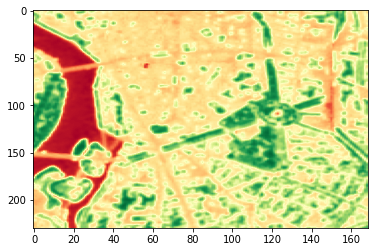

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(NDVI, cmap='RdYlGn', aspect='auto')
plt.savefig(os.path.join(workspace, 'ndvi_toulouse.png'))